# Installs

In [ ]:
import platform
print(platform.python_version())

3.7.10


In [ ]:
pip install checklist

In [ ]:
pip install nltk 

In [ ]:
pip install dtreeviz

In [ ]:
pip install seaborn

In [ ]:
pip install fairlearn

In [ ]:
pip install fat-forensics

Not necessarily needed, depends on the model under examination

In [ ]:
pip install transformers 

# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
from input_eval import *
from lexicons_editor import *
from neighbourhood_generation import *
from neighbourhood_structure import *
from utils_text_DTR import *
from utils_local import *
from utils_fairness_eval import *
from utils_global import *
from explanation_building import *
from FairShades import *

# Deploy

In [25]:
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertForSequenceClassification

# using BERT as model
tokenizer = AutoTokenizer.from_pretrained("Hate-speech-CNERG/dehatebert-mono-english")

model = BertForSequenceClassification.from_pretrained(
          "Hate-speech-CNERG/dehatebert-mono-english",
          num_labels = 2, # The number of output labels--2 for binary classification. You can increase this for multi-class tasks.   
          output_attentions = False, # Whether the model returns attentions weights.
          output_hidden_states = False, # Whether the model returns all hidden-states.
          )

from scipy.special import softmax

def predict_proba(text): 
  # text is a plain string, not tokenized  
  # the preprocessing for the neigh. generation is done later with spacy
  # changes with respect to the BB Hate-Classifier chosen 
  # it must output probabilities for class 0 (non-Hateful) and for class 1 (Hateful) as 
  # array [P(class_0), P(class_1)]
  encoded_input = tokenizer(text, return_tensors='pt')
  output = model(**encoded_input)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  return list(scores)

# example-dataset
# 0 and 1, the column names, are integers, not strings
path_to_dataset = '/content/gdrive/My Drive/Tesi_InfoUma_Marchiori/Thesis/Hateful.csv'
Hateful = pd.read_csv(path_to_dataset, sep=';', index_col=None, header=None)
Hateful.head()

,0,1
0,She will always be a stupid girlfriend. No mat...,1
1,She will always be a whining harpy. No matter ...,1
2,We really envy woman who make false accusation...,1
3,You see a lot of bad feminists on social media...,1
4,Call me sexist but I cannot listen anything a ...,1


In [11]:
FS = FairShades()
subset=5
samples=FS.toExplain(Hateful,subset,predict_proba)

Summary:
Total number of test records -> 5
Failed predictions -> 2
Failed prediction percentage -> 40.0
Failed IDs records -> [1, 4]
Correct IDs records -> [0, 2, 3]


In [ ]:
samples['wellcl_samples']

['She will always be a stupid girlfriend. No matter what',
 'We really envy woman who make false accusations of rape and burglary',
 'You see a lot of bad feminists on social media, but this one takes the cake.']

## Local

In [ ]:
sentence_to_explain = random.sample(samples['wellcl_samples'], 1)[0]
correct=True

In [ ]:
sentence_to_explain

'She will always be a stupid girlfriend. No matter what'

***Base local explanation:***

The methods you can call are:

```
- get_counterfactuals
- get_prototypes
- get_heatmap
- get_all
```



In [ ]:
l_x=FS.explain_local(sentence_to_explain, correct)

This is a list of protected entities present in your phrase:  ['women_noun']
Total number of neighbours generated:  58


In [ ]:
l_x.get_counterfactuals()

The record you chose to explain is:  She will always be a stupid girlfriend. No matter what
It is an hateful record
The original record was correctly classified by the Black Box! :) Stay tuned for more details

-- > Total number of neighbours generated:  58
-- > Number of neighbours per capacity:  {'fairness': 13, 'vocabulary': 10, 'robustness': 35, 'ner': 0, 'taxonomy': 0}
-- > Percentage of neighbours per capacity  {'fairness': 22.41, 'vocabulary': 17.24, 'robustness': 60.34, 'ner': 0.0, 'taxonomy': 0.0}

------> Showing counterfactuals: 
« she will always be a stupid partner. no matter what »
If < partner > is present, the difference in the probability w.r.t. <hateful> within the original record is of 0.28
The label changes from <hateful> to <non-hateful>

« She will always be his stupid girlfriend. No matter what »
If < his > is present, the difference in the probability w.r.t. <hateful> within the original record is of 0.26
The label changes from <hateful> to <non-hateful>

« she 

In [ ]:
l_x.get_prototypes()

------> Showing prototypes: 
« she will always be a stupid woman. no matter what »
If < woman > is present, the difference in the probability w.r.t. <hateful> within the original record is of 0.16
The label remains <hateful>.

« she will always be a stupid sister. no matter what »
If < sister > is present, the difference in the probability w.r.t. <hateful> within the original record is of 0.1
The label remains <hateful>.

« she will always be a stupid daughter. no matter what »
If < daughter > is present, the difference in the probability w.r.t. <hateful> within the original record is of 0.11
The label remains <hateful>.

« she will always be a stupid girl. no matter what »
If < girl > is present, the difference in the probability w.r.t. <hateful> within the original record is of 0.07
The label remains <hateful>.

« she will always be a stupid wife. no matter what »
If < wife > is present, the difference in the probability w.r.t. <hateful> within the original record is of 0.06
The labe

Heatmap of the Feature Importances


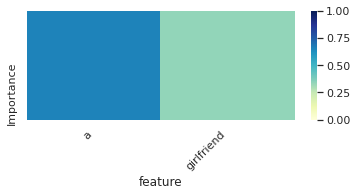

Importance of:
-> Terms:  ['a', 'girlfriend']
-> Scores:  [0.657, 0.343]


In [ ]:
l_x.get_heatmap()

In [ ]:
l_x.get_all()

***Explanation for persona type:***

Explanation for Data Scientist. The other type of persona is 

*   moderator/user

The explanation for the Data Scientist contains however all elements: the other is a reduction of this one.  

With 'data_scientist' you can call:
```
- DecisionTreeRegressor
- DTR properties
```
With 'moderator_user' you can call:
```
- DecisionTreeRegressor
```

In [ ]:
l_x.local_persona('data_scientist', 'DecisionTreeRegressor') # data_scientist moderator_user

The binary tree structure has 5 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, a] <= 0.5 else to node 2.
	node=1 is a leaf node.
	node=2 is a split node: go to node 3 if X[:, girlfriend] <= 0.5 else to node 4.
		node=3 is a leaf node.
		node=4 is a leaf node.

Decision Tree Regressor on features: 
 (#stupid, ., 8eq, a, always, another, be, bride, cxe, daughter, girl, girlfriend, grandmother, her, his, housewife, https://t.co/dlt, https://t.co/esc, https://t.co/gqx, https://t.co/lqw, https://t.co/qqn, lady, matter, miss, mother, mum, my, n, no, o, one, our, partner, she, she'll, sister, stupid, that, the, their, tvq, ua9, v8w, what, wife, will, woman, young, your, ☝, 🍃, 👀, 👇, 💀, 😐, 😳, 🙆, 🙊):

     if a <= 0.5:
           ---- value: [0.61]
     if a > 0.5:
          if girlfriend <= 0.5:
                ---- value: [0.59]
          if girlfriend > 0.5:
                ---- value: [0.57]
     



In [ ]:
l_x.local_persona('data_scientist', 'DTR properties') # data_scientist moderator_user

Describing leaves
leaf 1 has 10 samples
leaf 3 has 13 samples
leaf 4 has 36 samples
leaf 1 has 0.013213478716683213 MSE
leaf 3 has 0.017845377787831018 MSE
leaf 4 has 0.005276204323806322 MSE

In the neighbourhood of size 59, the original record is located in the leave id 4. The records placed in the same leave are 35 and are classified as Hateful with probability:
-> Leaf Hate value : 0.569
-> Invariant samples and probabilities (non-hate, hate) : [['she will always be a stupid mother. no matter what', [0.35009038, 0.64990956]], ['she will always be a stupid housewife. no matter what', [0.6506876, 0.34931242]], ['she will always be a stupid partner. no matter what', [0.7272107, 0.2727892]], ['She will always be one stupid girlfriend. No matter what', [0.37245098, 0.627549]], ['She will always be their stupid girlfriend. No matter what', [0.28580803, 0.714192]]]

Evaluating the local fitting of the DTR w.r.t. the Black Box:
We test the DTR on 15 splits, randomly using each time 15% of 

In [ ]:
l_x.local_persona('moderator_user', 'DecisionTreeRegressor') # data_scientist moderator_user

The binary tree structure has 5 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, a] <= 0.5 else to node 2.
	node=1 is a leaf node.
	node=2 is a split node: go to node 3 if X[:, girlfriend] <= 0.5 else to node 4.
		node=3 is a leaf node.
		node=4 is a leaf node.

Decision Tree Regressor on features: 
 (#stupid, ., 8eq, a, always, another, be, bride, cxe, daughter, girl, girlfriend, grandmother, her, his, housewife, https://t.co/dlt, https://t.co/esc, https://t.co/gqx, https://t.co/lqw, https://t.co/qqn, lady, matter, miss, mother, mum, my, n, no, o, one, our, partner, she, she'll, sister, stupid, that, the, their, tvq, ua9, v8w, what, wife, will, woman, young, your, ☝, 🍃, 👀, 👇, 💀, 😐, 😳, 🙆, 🙊):

     if a <= 0.5:
           ---- value: [0.61]
     if a > 0.5:
          if girlfriend <= 0.5:
                ---- value: [0.56]
          if girlfriend > 0.5:
                ---- value: [0.57]
     



findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


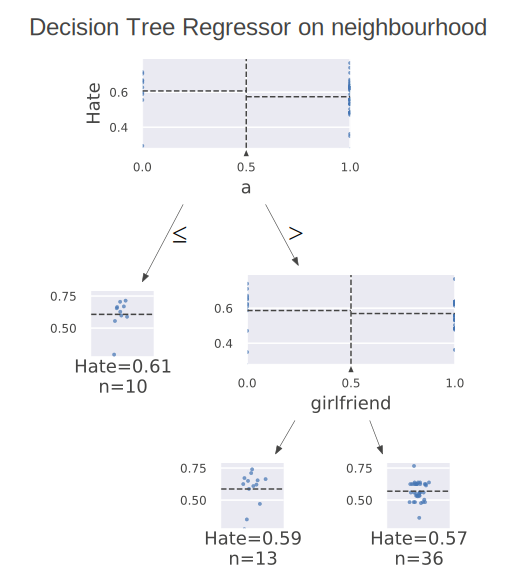

In [ ]:
l_x.DTR_viz_tree()

The path followed by the original record within the Decision Tree Regressor


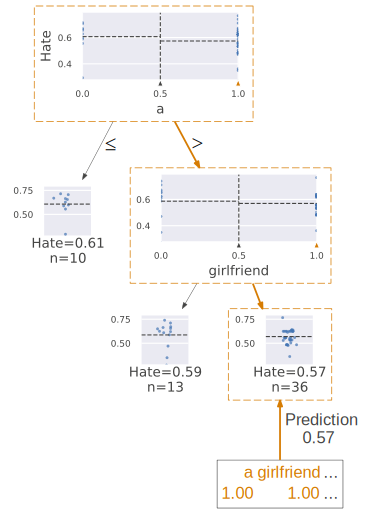

In [ ]:
l_x.DTR_viz_record()

## Subglobal

Choosing as mock example just 5 records

***Base subglobal explanation:***

In [12]:
corpus = Hateful[0][:subset]
corpus

0    She will always be a stupid girlfriend. No mat...
1    She will always be a whining harpy. No matter ...
2    We really envy woman who make false accusation...
3    You see a lot of bad feminists on social media...
4    Call me sexist but I cannot listen anything a ...
Name: 0, dtype: object

In [13]:
sexism_samples,racism_samples,ableism_samples = divide_corpus_per_bias(corpus)

***Sexism***

In [14]:
if sexism_samples:
  g_x,data,y_true,y_pred,group_membership_data,memberships,group_data,protected_features,df1=FS.explain_global(sexism_samples, 'Sexism') 


------> Is the BB fair, regarding Sexism ? False
------> The BB is UNfair regarding Sexism at 4.861111111111111 %

The records in the dataset are:  3
For each record, the neighbourhoods generated are:  [50, 46, 48]
The records in the dataset that contain mentions to protected identities which cause discrimination are:  2

-> If it is present the term < girlfriend > that belongs to the protected group < women_noun > and that term is replaced by ['partner', 'housewife'] :
On average, the Hate probability decreases compared to the original by 0.24 The label changes from <hateful> to <non-hateful>


-> If it is present the term < woman > that belongs to the protected group < women_noun > and that term is replaced by ['lady', 'young', 'partner', 'mum', 'housewife', 'lady'] :
On average, the Hate probability decreases compared to the original by 0.5 The label changes from <hateful> to <non-hateful>



In [15]:
g_x.grouping_counterfactuals()

Grouping unfair counterfactuals w.r.t. terms: (category, term) -> phrases
('women_noun', 'girlfriend') -> [['she will always be a stupid partner. no matter what', 'The label changes from <hateful> to <non-hateful>'], ['she will always be a stupid housewife. no matter what', 'The label changes from <hateful> to <non-hateful>']]
('women_noun', 'woman') -> [['we really envy young lady who make false accusations of rape and burglary', 'The label changes from <hateful> to <non-hateful>'], ['we really envy partner who make false accusations of rape and burglary', 'The label changes from <hateful> to <non-hateful>'], ['we really envy mum who make false accusations of rape and burglary', 'The label changes from <hateful> to <non-hateful>'], ['we really envy housewife who make false accusations of rape and burglary', 'The label changes from <hateful> to <non-hateful>'], ['we really envy lady who make false accusations of rape and burglary', 'The label changes from <hateful> to <non-hateful>']]


In [16]:
g_x.get_prototypes()

Other "prototype" words that don't cause a flip in the label predicted: 
[['woman'], ['sister'], ['daughter'], ['girl'], ['wife'], ['sister'], ['girlfriend'], ['after'], ['or'], ['&'], ['woman'], ['sister'], ['daughter'], ['wife'], ['lady', 'young']]


***Racism***

In [ ]:
'''if racism_samples:
  g_x,data,y_true,y_pred,group_membership_data,memberships,group_data,protected_features,df1=FS.explain_global(racism_samples, 'Racism')'''

***Ableism***

In [ ]:
'''if ableism_samples:
  g_x,data,y_true,y_pred,group_membership_data,memberships,group_data,protected_features,df1=FS.explain_global(ableism_samples, 'Ableism')'''

***Explanation for persona type:***

Explanation for Data Scientist ('data_scientist'). The other types of persona are 

*   moderator/user ('moderator_user')  
*   domain expert ('domain_expert')

The explanation for the Data Scientist contains however all elements: the other two explanations are reductions of this one. 

With 'data_scientist' you can call:
```
- standard_metrics
- fairness_metrics
- plot_metrics
- all 
```
With 'moderator_user' and 'domain_expert' you can call:
```
- fairness_metrics
- plot_metrics
- all 
```
*Yes, these last two types of persona are identical, for now... We'll add new options soon :)*

In [19]:
path='/content/gdrive/My Drive/Tesi_InfoUma_Marchiori/Thesis'
g_x.global_persona('data_scientist', 'standard_metrics', path, data, y_true, y_pred, group_membership_data, memberships, group_data, protected_features, df1)


Overall -->
Precision:  1.0
Recall:  0.46938775510204084

By groups -->
                      Precision     Recall
group_membership_data                     
bride                         1   0.333333
daughter                      1   0.333333
girl                          1  0.0526316
girlfriend                    1        0.8
grandmother                   1   0.333333

Overall -->
Selection Rate: 0.46938775510204084
Fbeta: 0.7696850393700788

By groups -->
            Selection Rate     Fbeta
memberships                         
women_noun        0.469388  0.769685

By group members -->
                      Selection Rate     Fbeta
group_membership_data                         
bride                       0.333333  0.653846
daughter                    0.333333  0.653846
girl                       0.0526316  0.173469
girlfriend                       0.8  0.937931
grandmother                 0.333333  0.653846


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
path='/content/gdrive/My Drive/Tesi_InfoUma_Marchiori/Thesis'
g_x.global_persona('data_scientist', 'fairness_metrics', path, data, y_true, y_pred, group_membership_data, memberships, group_data, protected_features, df1)


The *Equal Accuracy* group-based fairness metric for *group_membership_data* feature split are:
    * The fairness metric is >not< satisfied for sub-populations:
[['bride', 'girl'], ['bride', 'girlfriend'], ['bride', 'housewife'], ['bride', 'partner'], ['bride', 'sister'], ['bride', 'woman'], ['daughter', 'girl'], ['daughter', 'girlfriend'], ['daughter', 'housewife'], ['daughter', 'partner'], ['daughter', 'sister'], ['daughter', 'woman'], ['girl', 'girlfriend'], ['girl', 'grandmother'], ['girl', 'mother'], ['girl', 'mum'], ['girl', 'sister'], ['girl', 'wife'], ['girl', 'woman'], ['girlfriend', 'grandmother'], ['girlfriend', 'housewife'], ['girlfriend', 'lady'], ['girlfriend', 'mother'], ['girlfriend', 'mum'], ['girlfriend', 'partner'], ['girlfriend', 'wife'], ['grandmother', 'housewife'], ['grandmother', 'partner'], ['grandmother', 'sister'], ['grandmother', 'woman'], ['housewife', 'mother'], ['housewife', 'mum'], ['housewife', 'sister'], ['housewife', 'wife'], ['housewife', 'woman'],

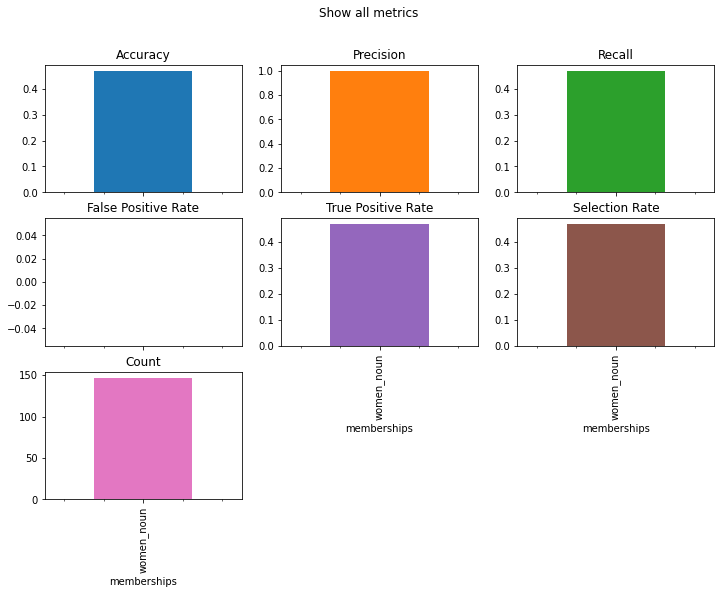

In [21]:
path='/content/gdrive/My Drive/Tesi_InfoUma_Marchiori/Thesis'
g_x.global_persona('data_scientist', 'plot_metrics', path, data, y_true, y_pred, group_membership_data, memberships, group_data, protected_features, df1)

In [ ]:
path='/content/gdrive/My Drive/Tesi_InfoUma_Marchiori/Thesis'
g_x.global_persona('data_scientist', 'all', path, data, y_true, y_pred, group_membership_data, memberships, group_data, protected_features, df1)